In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import gc
import time
import os

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
!pip cache purge
!pip install --no-cache-dir sdv

Files removed: 0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 333.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 347.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 277.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 288.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 344.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 348.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 308.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 353.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 355.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 357.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 380.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [5]:
from sdv.single_table import TVAESynthesizer
from sdv.metadata import Metadata

In [6]:
from google.colab import drive
import pandas as pd
from sklearn.utils import resample
import transformers
import re
import traceback
import random

In [7]:
import transformers
print(transformers.__version__)

4.51.3


Prepare July Data

In [8]:
dfjuly = pd.read_csv("df_julyweek5.csv")
dfjuly.head()


,Date,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,Label,U,A,P,R,S,F
0,2016-07-28 00:51:51,0.000,52771,9594,6,0,1,44,scan44,0,0,0,0,1,0
1,2016-07-28 00:50:18,0.000,49175,38412,6,0,1,40,scan44,0,1,0,1,0,0
2,2016-07-27 13:59:02,0.000,33168,80,6,0,1,52,background,0,1,0,0,0,1
3,2016-07-28 00:51:19,0.000,47828,5414,6,0,1,44,scan44,0,0,0,0,1,0
4,2016-07-27 17:14:28,0.708,56698,25,6,0,6,440,anomaly-spam,0,1,1,1,1,0


In [9]:
def map_classes(label):
    label = label.lower()
    if label.startswith('background'):
        return 0
    elif label.startswith('dos'):
        return 1
    elif label.startswith('nerisbotnet'):
        return 2
    elif label.startswith('scan44'):
        return 3
    elif label.startswith('anomaly-spam'):
        return 4

# Apply the mapping function to the 'Label' column
dfjuly['Class'] = dfjuly['Label'].apply(map_classes)
dfjuly['Class'] = dfjuly['Class'].astype(int)

In [10]:
def map_labels(label):
    label = label.lower()
    if label.startswith('background'):
        return 'Benign'
    elif label.startswith('dos'):
        return 'DoS'
    elif label.startswith('nerisbotnet'):
        return 'Botnet'
    elif label.startswith('scan44'):
        return 'Scan44'
    elif label.startswith('anomaly-spam'):
        return 'Spam'

# Apply the mapping function to the 'Label' column
dfjuly['Label'] = dfjuly['Label'].apply(map_labels)

In [11]:
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
Scan44,17500
Spam,17500
Botnet,17500
DoS,17500


In [12]:
dfbefore=dfjuly.copy()

In [13]:
dfjuly.Class.value_counts()

,count
Class,
0,30000
3,17500
4,17500
2,17500
1,17500


In [14]:
#reduce samples of minority class
spam_reduced_july = dfjuly[dfjuly.Label == "Spam"].sample(n=2000, random_state=42)
botnet_reduced_july = dfjuly[dfjuly.Label== "Botnet"].sample(n=2000, random_state=42)
dfjuly = dfjuly[~dfjuly.Label.isin(["Spam", "Botnet"])]
dfjuly= pd.concat([spam_reduced_july, botnet_reduced_july, dfjuly])
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [15]:
dfjuly.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [16]:
dfjuly = dfjuly.drop(columns=['Date', 'Label'])

In [17]:
print(dfjuly.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [18]:
dforiginal=dfjuly.copy()

In [19]:
botnet_orig = dfjuly[dfjuly.Class == 2]
spam_orig = dfjuly[dfjuly.Class == 4]

Split Train/Test

In [21]:
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [22]:
clf_name_mlp = 'MLP'
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,100))

In [ ]:
clf_name_xgb = 'XGBoost'
xgb_classifier = xgb.XGBClassifier(max_depth=5, objective='multi:softprob', n_estimators=1000, num_classes=5)

In [ ]:
# fit algorithm to data
def fit_algo(algo, train_x, train_y):

    model = algo.fit(train_x, train_y)
    gc.collect()
    return model

def train_and_test(clf_name, clf, results, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model = fit_algo(clf, X_train, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred, average=None)
    f1_avg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate FPR and FNR for each class
    class_fpr = []
    class_fnr = []

    for i in range(conf_matrix.shape[0]):
        tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # sum of all non-i cells
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # sum of i-th column, excluding diagonal
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]  # sum of i-th row, excluding diagonal
        tp = conf_matrix[i, i]  # i-th diagonal element

        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0  # Avoid division by zero

        class_fpr.append(fpr)
        class_fnr.append(fnr)

    # Overall FPR and FNR (averaging across classes)
    avg_fpr = np.mean(class_fpr)
    avg_fnr = np.mean(class_fnr)

    return f1, f1_avg, train_time, conf_matrix, class_fpr, class_fnr, avg_fpr, avg_fnr

def preprocess_data(df):
    df_copy = df.copy()

    X = df_copy.drop('Class', axis=1)
    y = df_copy['Class']

    X = X.apply(pd.to_numeric, errors='coerce')

    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)

    # Double-check that no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaNs detected in data after preprocessing. Check data sources or methods.")
        X.fillna(0, inplace=True)  # Fallback option: replace any remaining NaNs with 0

    return X.values, y.values

# Preprocess data
X_july, y_july = preprocess_data(dfjuly)


In [ ]:
# Function to generate synthetic data
def generate_synthetic(df, multiplier):
  classes_to_keep = [4]

  filtered_df = df[df['Class'].isin(classes_to_keep)]

  filtered_df.Class.value_counts()

  n_samples = len(filtered_df) * multiplier

  # Initialize TVAE model
  metadata = Metadata.detect_from_dataframe(
      data=filtered_df
  )
  synthesizer = TVAESynthesizer(
      metadata,
      epochs=3
  )

  # Fit the model on the filtered dataset
  synthesizer.fit(filtered_df)

  df['Class'] = df['Class'].astype(str)

  samples = synthesizer.sample(num_rows=n_samples)

  return samples

In [ ]:
synthetic_samples = generate_synthetic(dfbefore, 3)
X_synthetic = synthetic_samples.drop(columns=['Class']).values
y_synthetic = synthetic_samples['Class'].values

# synthetic_samples_class_2 = synthetic_samples[synthetic_samples['Class'] == 2]
synthetic_samples_class_4 = synthetic_samples[synthetic_samples['Class'] == 4]

# synthetic_samples_class_2.to_csv('Reverse_LLM_Generated_Botnet_only_July_3X.csv', index=False)
synthetic_samples_class_4.to_csv('TVAE_Generated_Spam_July.csv', index=False)

print("Synthetic samples saved successfully!")


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:122: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Synthetic samples saved successfully!


In [23]:
botnet_gen = pd.read_csv("/content/TVAE_Generated_Botnet_July.csv")
spam_gen = pd.read_csv("/content/TVAE_Generated_Spam_July.csv")

In [24]:
botnet_gen.drop(columns=['Date', 'Label'], inplace=True)
spam_gen.drop(columns=['Date', 'Label'], inplace=True)

In [25]:
print(botnet_gen.columns)
print(spam_gen.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [26]:
print(botnet_gen.shape)
print(spam_gen.shape)

(52500, 14)
(52500, 14)


JSD

In [27]:
from scipy.spatial.distance import jensenshannon

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

def average_jsd(df1, df2, features, bins=50):
    jsd_values = []
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  # Actual JSD
        jsd_values.append(jsd)

    avg_jsd = np.mean(jsd_values)
    return avg_jsd

avg_jsd_botnet = average_jsd(botnet_orig, botnet_gen, selected_features)
avg_jsd_spam = average_jsd(spam_orig, spam_gen, selected_features)

print("Average JSD (Botnet):", avg_jsd_botnet)
print("Average JSD (Spam):", avg_jsd_spam)

Average JSD (Botnet): 0.09149396007071313
Average JSD (Spam): 0.1101483277042403


Feature- wise JSD

In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np

def jsd_per_feature(df1, df2, features, bins=50):
    jsd_dict = {}
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  # Actual JSD
        jsd_dict[feature] = jsd
    return jsd_dict

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

jsd_botnet = jsd_per_feature(botnet_orig, botnet_gen, selected_features)
jsd_spam = jsd_per_feature(spam_orig, spam_gen, selected_features)

print("JSD per feature (Botnet):")
for feature, jsd in jsd_botnet.items():
    print(f"{feature}: {jsd:.4f}")

print("\nJSD per feature (Spam):")
for feature, jsd in jsd_spam.items():
    print(f"{feature}: {jsd:.4f}")

JSD per feature (Botnet):
Packets: 0.0401
Duration: 0.1207
Bytes: 0.0035
Src_Port: 0.1614
Dest_Port: 0.1318

JSD per feature (Spam):
Packets: 0.1396
Duration: 0.0601
Bytes: 0.0472
Src_Port: 0.1508
Dest_Port: 0.1530


CDF

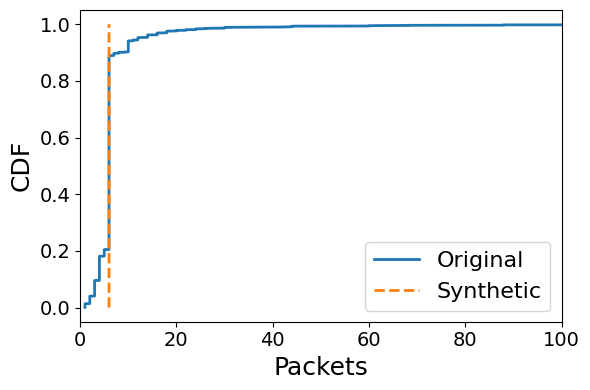

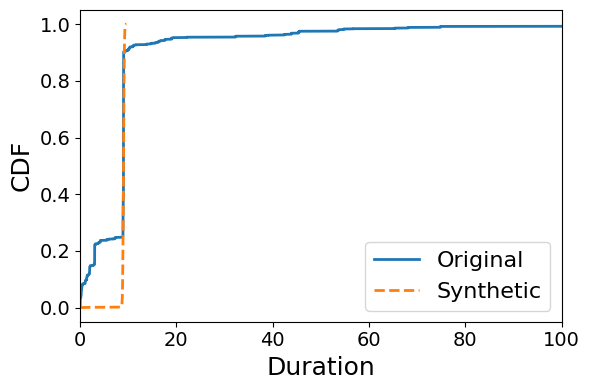

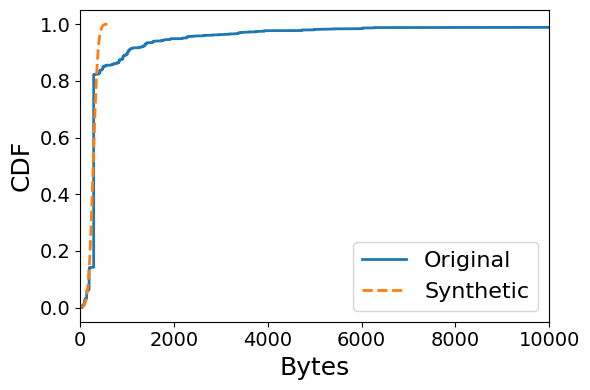

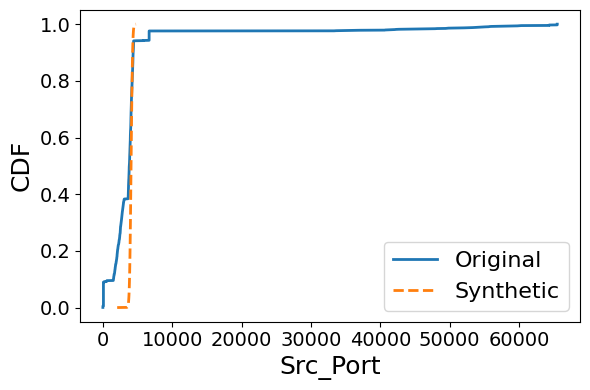

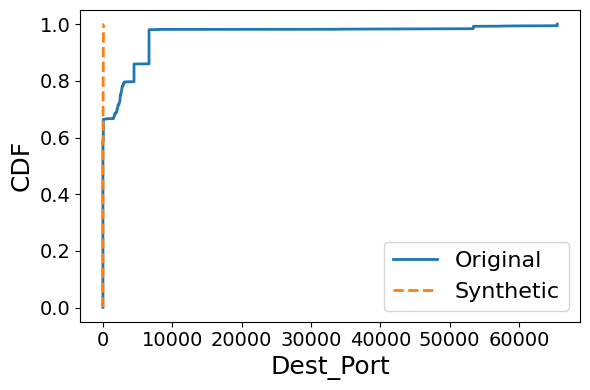

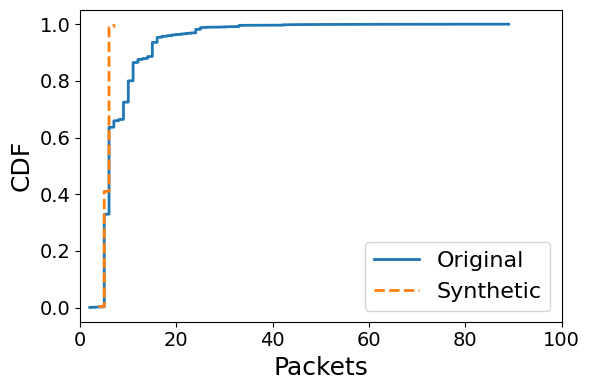

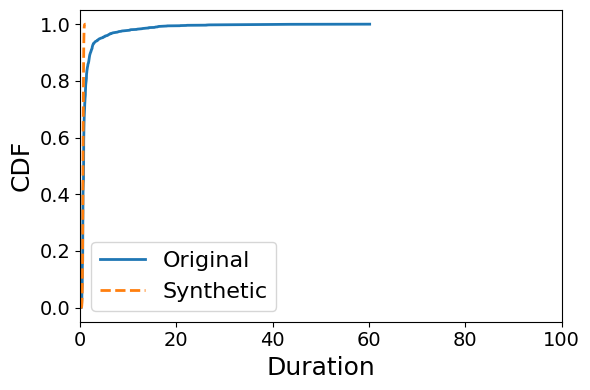

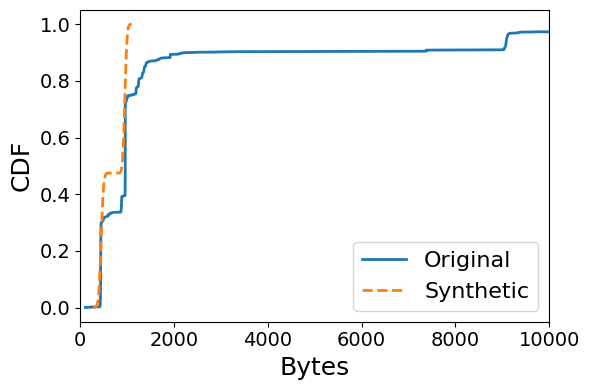

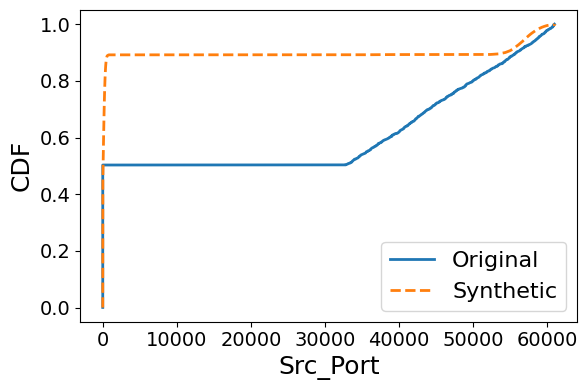

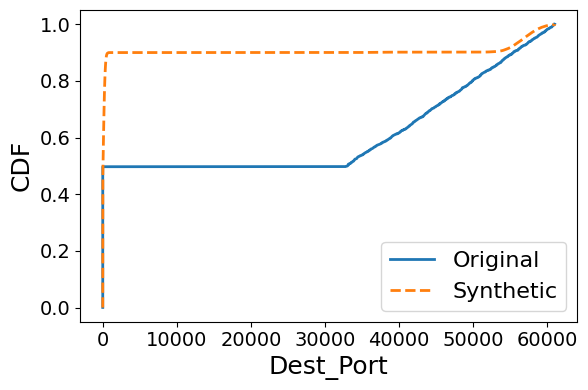

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdfs(original_df, generated_df, features):
    for feature in features:
        orig_values = np.sort(original_df[feature].dropna())
        gen_values = np.sort(generated_df[feature].dropna())

        orig_cdf = np.arange(1, len(orig_values)+1) / len(orig_values)
        gen_cdf = np.arange(1, len(gen_values)+1) / len(gen_values)

        plt.figure(figsize=(6, 4))
        plt.plot(orig_values, orig_cdf, label='Original', linewidth=2)
        plt.plot(gen_values, gen_cdf, label='Synthetic', linewidth=2, linestyle='--')
        plt.xlabel(feature, fontsize=18)
        plt.ylabel("CDF", fontsize=18)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16)
        if feature == 'Packets' or feature == 'Duration':
            plt.xlim(0, 100)
        elif feature == 'Bytes':
            plt.xlim(0, 10000)
        elif feature == 'Src_port':
            plt.xlim(0, 2000)
        plt.tight_layout()
        plt.show()
plot_cdfs(botnet_orig, botnet_gen, selected_features)
plot_cdfs(spam_orig, spam_gen, selected_features)

W2 distance

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def compute_scaled_wasserstein_distances(df1, df2, features):
    scaler = MinMaxScaler()
    distances = {}

    for feature in features:
        combined = pd.concat([df1[feature], df2[feature]]).values.reshape(-1, 1)
        scaled = scaler.fit_transform(combined).flatten()

        split = len(df1[feature])
        scaled1 = scaled[:split]
        scaled2 = scaled[split:]

        distances[feature] = wasserstein_distance(scaled1, scaled2)

    return distances

w_scaled_botnet = compute_scaled_wasserstein_distances(botnet_orig, botnet_gen, selected_features)
w_scaled_spam = compute_scaled_wasserstein_distances(spam_orig, spam_gen, selected_features)

print("Wasserstein distances (Botnet):")
for k, v in w_scaled_botnet.items():
    print(f"{k}: {v:.4f}")

print("\nWasserstein distances (Spam):")
for k, v in w_scaled_spam.items():
    print(f"{k}: {v:.4f}")

Wasserstein distances (Botnet):
Packets: 0.0090
Duration: 0.0166
Bytes: 0.0041
Src_Port: 0.0323
Dest_Port: 0.0371

Wasserstein distances (Spam):
Packets: 0.0302
Duration: 0.0138
Bytes: 0.0286
Src_Port: 0.2826
Dest_Port: 0.2939


Violin plot

<ipython-input-143-52d531186ad0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')


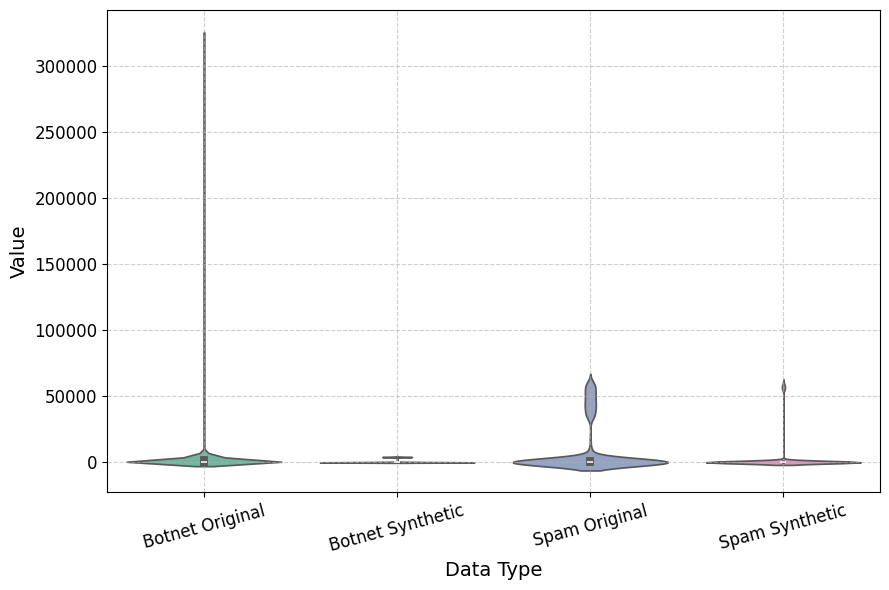

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, features):
    data = []
    labels = []

    for label, df in zip(
        ['Botnet Original', 'Botnet Synthetic', 'Spam Original', 'Spam Synthetic'],
        [botnet_orig, botnet_gen, spam_orig, spam_gen]
    ):
        for feature in features:
            data.extend(df[feature].dropna().values)
            labels.extend([label] * df[feature].dropna().shape[0])

    df_combined = pd.DataFrame({'Value': data, 'Type': labels})

    plt.figure(figsize=(9, 6))
    sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')

    plt.ylabel("Value", fontsize=14)
    plt.xlabel("Data Type", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']
combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, selected_features)


Heatmaps

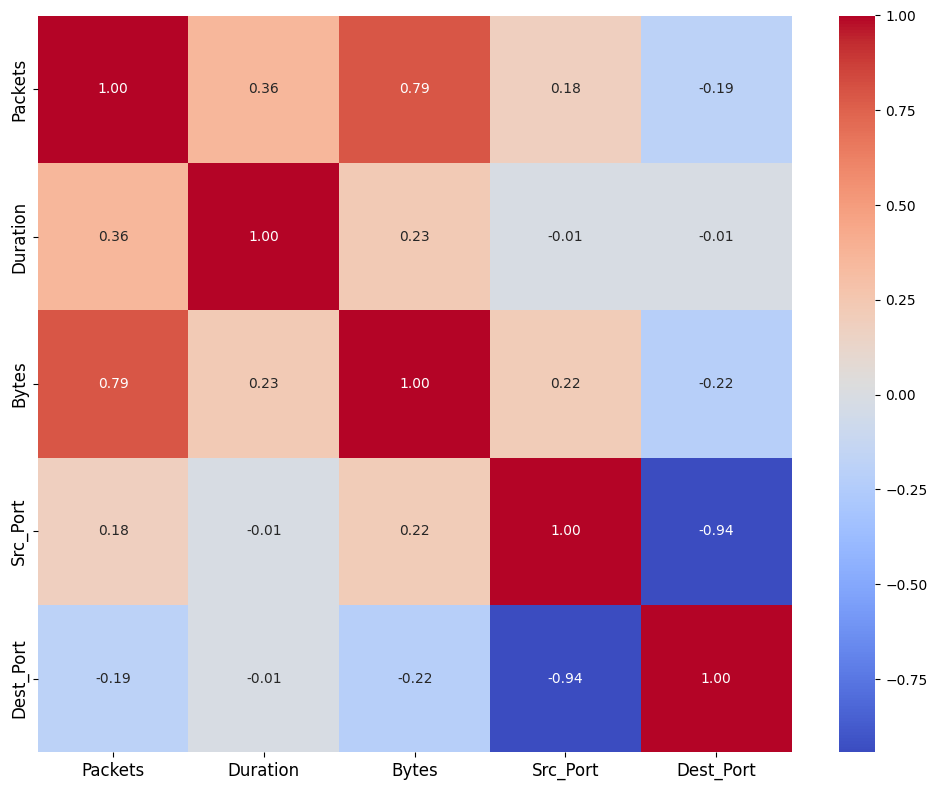

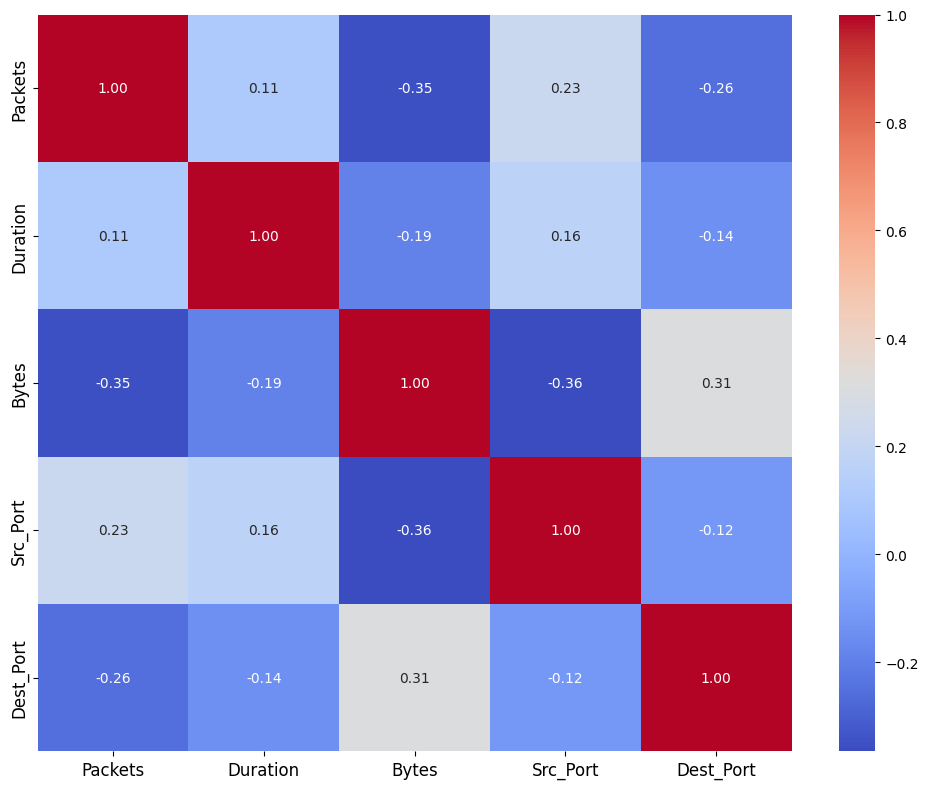

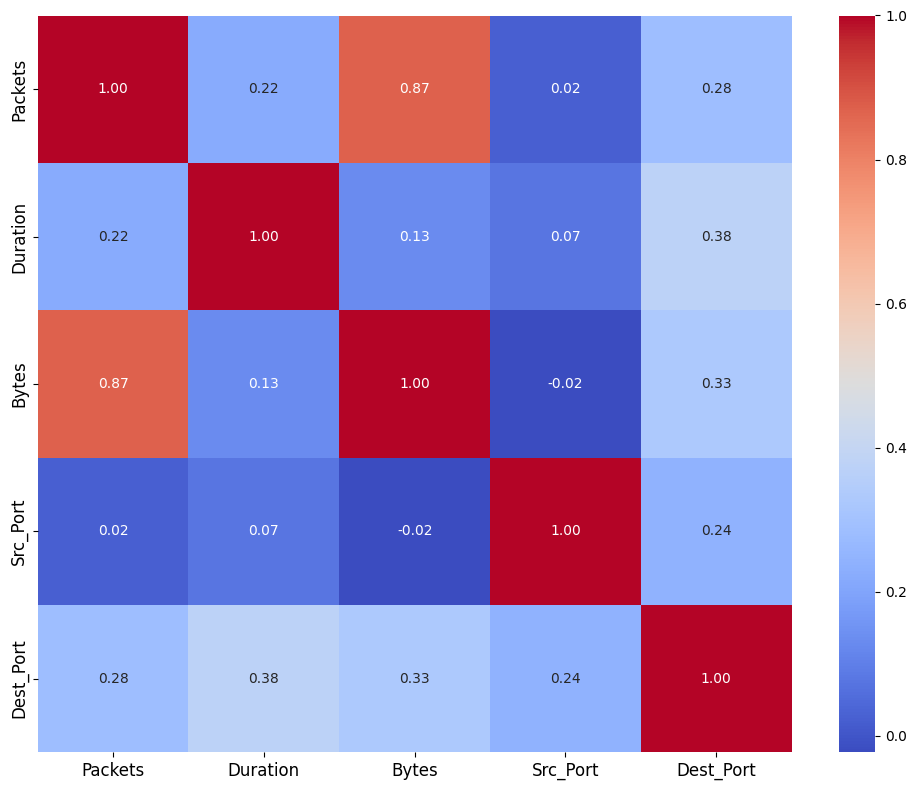

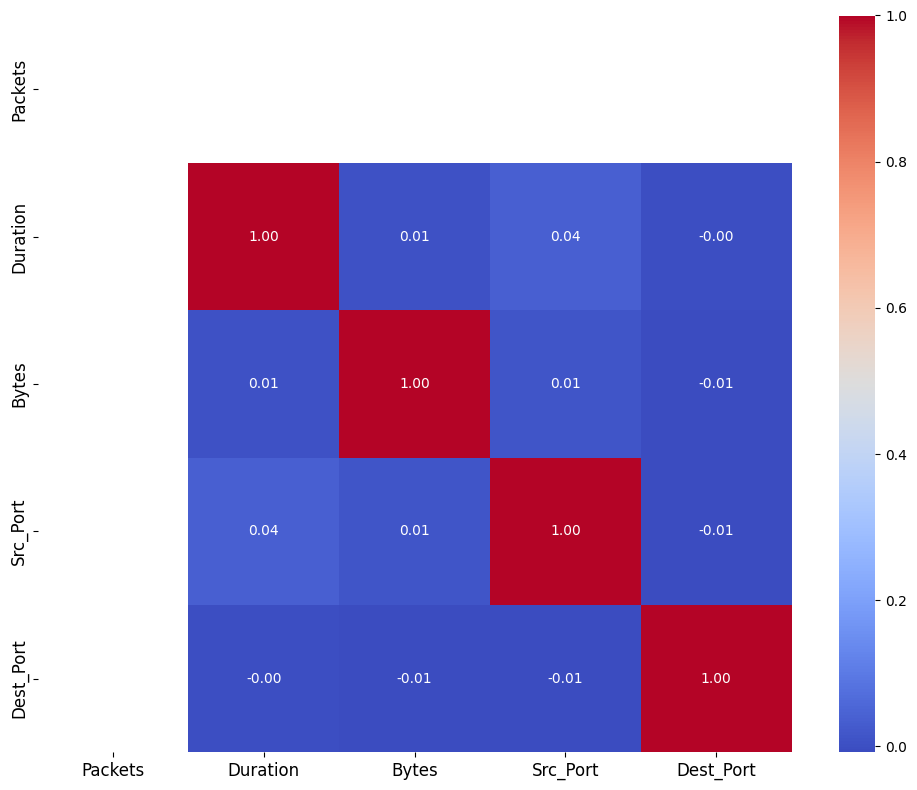

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()  # Correlation matrix
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

plot_heatmap(spam_orig[selected_features])
plot_heatmap(spam_gen[selected_features])
plot_heatmap(botnet_orig[selected_features])
plot_heatmap(botnet_gen[selected_features])


In [ ]:
print(spam_gen.columns)
print(selected_features)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']


pMSE

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

def compute_pmse(original_df, synthetic_df, features=None, test_size=0.3, random_state=42):
    if features is None:
        features = list(set(original_df.columns) & set(synthetic_df.columns))
        features = [f for f in features if pd.api.types.is_numeric_dtype(original_df[f])]

    original_df = original_df[features].copy()
    synthetic_df = synthetic_df[features].copy()
    original_df['label'] = 0
    synthetic_df['label'] = 1

    #shuffle data
    combined = pd.concat([original_df, synthetic_df], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

    #split into train,test
    X = combined[features]
    y = combined['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Logistic regression Classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    #probabilities
    p_hat = clf.predict_proba(X_test)[:, 1]
    pmse = np.mean((p_hat - 0.5) ** 2)
    return pmse

pmse_botnet = compute_pmse(botnet_orig, botnet_gen)
pmse_spam = compute_pmse(spam_orig, spam_gen)

print(f"pMSE Botnet: {pmse_botnet:.4f}")
print(f"pMSE Spam: {pmse_spam:.4f}")


pMSE Botnet: 0.2288
pMSE Spam: 0.2276


Mahalanobis distance outlier filtering

       Duration  Src_Port  Dest_Port  Protocol  TOS  Packets  Bytes  U  A  P  \
0         9.021      4175         61         6    0        6    352  0  0  0   
1         9.274      3955         53         6    0        6    219  0  0  0   
2         8.911      3900         53         6    0        6    288  0  0  0   
3         8.861      3995         21         6    0        6    269  0  0  0   
4         8.911      3630         91         6    0        6    384  0  0  0   
...         ...       ...        ...       ...  ...      ...    ... .. .. ..   
52495     9.192      4116         44         6    0        6    333  0  0  0   
52496     9.048      4137         17         6    0        6    286  0  0  0   
52497     8.897      4111         32         6    0        6    285  0  0  0   
52498     9.133      3956         32         6    0        6    142  0  0  0   
52499     9.047      3850         17         6    0        6    272  0  0  0   

       R  S  F  Class  
0      0  1  0 

(array([4.0000e+00, 3.2000e+01, 2.4400e+02, 9.4500e+02, 2.8420e+03,
        6.2670e+03, 9.9990e+03, 1.1538e+04, 9.1750e+03, 5.9790e+03,
        3.1500e+03, 1.4110e+03, 5.7700e+02, 1.9800e+02, 7.1000e+01,
        2.2000e+01, 1.2000e+01, 3.0000e+00, 3.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        3.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        5.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.61741561, 0.62019234, 0.62296907, 0.6257458 , 0.62852254,
        0.63129927, 0.634076  , 0.63685273, 0.63962946, 0.6424062 ,
        0.64518293, 0.64795966, 0.65073639, 0.65351313, 0.65628986,
        0.65906659, 0.66184332, 0.66462005, 0.66739679, 0.67017352,
        0.67295025, 0.67572698, 0.67850372, 0.

Text(0.5, 1.0, 'Mahalanobis Distance of Synthetic Samples')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Frequency')

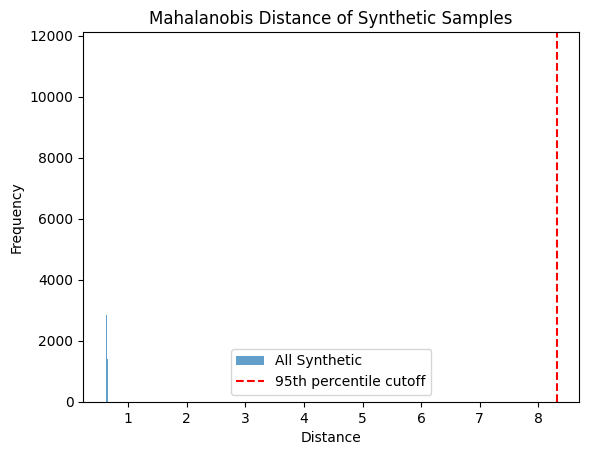

In [ ]:

from scipy.spatial import distance
import numpy as np

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)


#botnet
mu = np.mean(X_real_botnet_scaled, axis=0)
cov = np.cov(X_real_botnet_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_botnet_scaled]

#spam
mu = np.mean(X_real_spam_scaled, axis=0)
cov = np.cov(X_real_spam_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances_spam = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_spam_scaled]

# Keep samples within a threshold (e.g., 95th percentile)
threshold = np.percentile(distances, 95)
filtered_X_botnet_synth = botnet_gen[np.array(distances) < threshold]

# Keep samples within a threshold (e.g., 95th percentile)
threshold = np.percentile(distances_spam, 95)
filtered_X_spam_synth = spam_gen[np.array(distances_spam) < threshold]

print(filtered_X_botnet_synth)
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

import matplotlib.pyplot as plt

plt.hist(distances, bins=50, alpha=0.7, label='All Synthetic')
plt.axvline(threshold, color='red', linestyle='--', label='95th percentile cutoff')
plt.title("Mahalanobis Distance of Synthetic Samples")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np

X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_X_botnet_synth, filtered_X_spam_synth], ignore_index=True)

y_train = pd.concat([
    y_train_orig,
    pd.Series([2] * len(filtered_X_botnet_synth)),
    pd.Series([4] * len(filtered_X_spam_synth))
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)

#Map
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}
y_test_class = y_test.map(class_labels)
y_pred_mlp_class = pd.Series(y_pred_mlp).map(class_labels)

print("=== MLP Classification Report ===")
print(classification_report(y_test_class, y_pred_mlp_class))

# confusion matrix
cm = confusion_matrix(y_test_class, y_pred_mlp_class)
print("\nConfusion Matrix:\n", cm)

fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test)


from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# PRAUC per class
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


Label distribution in training set:
 4    51275
2    51275
0    21000
1    12250
3    12250
Name: count, dtype: int64


MLPClassifier(hidden_layer_sizes=(100, 100))

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98      9000
      Botnet       0.96      0.92      0.94       600
         DoS       1.00      1.00      1.00      5250
      Scan44       0.99      0.99      0.99      5250
        Spam       0.79      0.88      0.83       600

    accuracy                           0.98     20700
   macro avg       0.94      0.95      0.95     20700
weighted avg       0.98      0.98      0.98     20700


Confusion Matrix:
 [[8761   23    1   76  139]
 [  46  554    0    0    0]
 [   0    0 5250    0    0]
 [  34    0    0 5216    0]
 [  74    0    0    0  526]]

False Negative Rate (FNR) per class:
Class Benign: 0.0266
Class DoS: 0.0767
Class Botnet: 0.0000
Class Scan44: 0.0065
Class Spam: 0.1233

False Positive Rate (FPR) per class:
Class Benign: 0.0132
Class DoS: 0.0011
Class Botnet: 0.0001
Class Scan44: 0.0049
Class Spam: 0.0069

Precision-Recall AUC (PRAUC) per class:

In [ ]:
filtered_X_botnet_md= filtered_X_botnet_synth
filtered_X_spam_md = filtered_X_spam_synth

In [ ]:
filtered_X_botnet_synth.to_csv('TVAE_MD_botnet_July.csv', index=False)
filtered_X_spam_synth.to_csv('TVAE_MD_spam_July.csv', index=False)

In [ ]:
print(len(X_real_spam_scaled))

2000


In [ ]:
len(X_synth_spam_scaled)

52500

t-SNE graphs

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


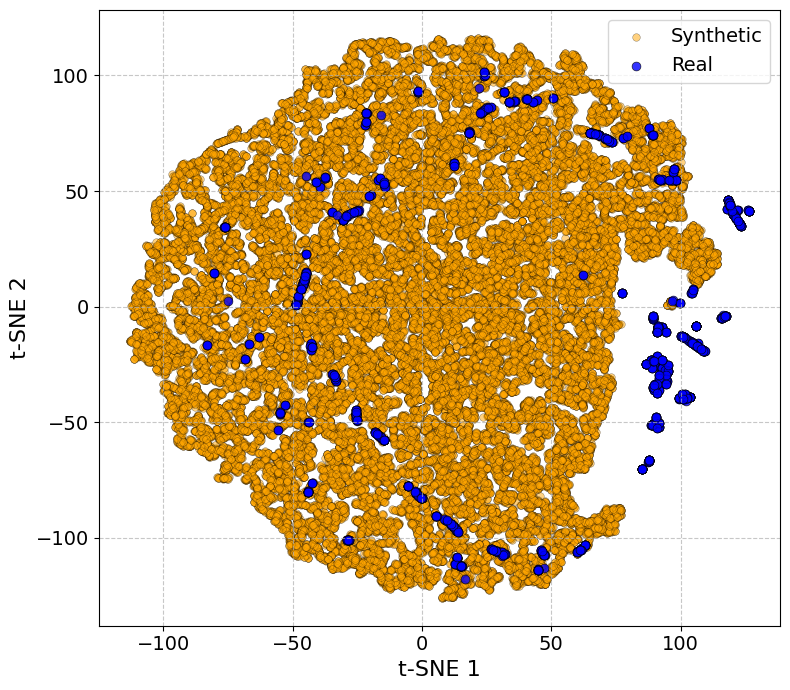

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


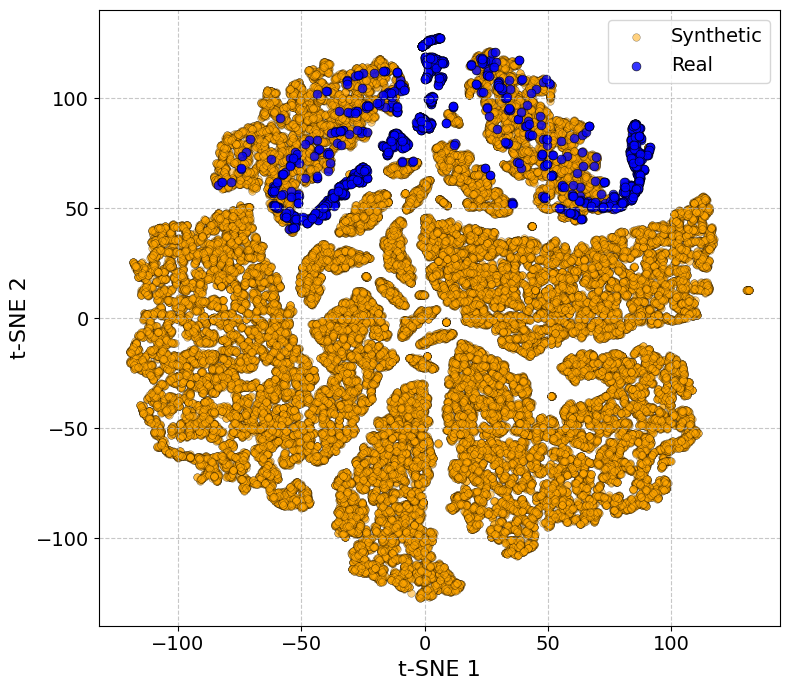

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(real_scaled, synth_scaled, title):
    combined = np.vstack([real_scaled, synth_scaled])
    labels = np.array([0] * len(real_scaled) + [1] * len(synth_scaled))

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 7))

    #Synthetic
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
                c='orange', label='Synthetic', alpha=0.5, s=30,
                edgecolors='k', linewidths=0.3)

    #Real
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
                c='blue', label='Real', alpha=0.8, s=40,
                edgecolors='k', linewidths=0.5)

    plt.legend(fontsize=14)
    plt.xlabel("t-SNE 1", fontsize=16)
    plt.ylabel("t-SNE 2", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)  # Tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


plot_tsne(X_real_botnet_scaled, X_synth_botnet_scaled, "Botnet")
plot_tsne(X_real_spam_scaled, X_synth_spam_scaled, "Spam")


One class- SVM

In [ ]:
from sklearn.svm import OneClassSVM


ocsvm_botnet = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  # nu=0.05 allows ~5% outliers
ocsvm_botnet.fit(X_real_botnet_scaled)
scores_botnet = ocsvm_botnet.predict(X_synth_botnet_scaled)  # -1 for outlier, 1 for inlier
filtered_ocsvm_botnet = botnet_gen[np.array(scores_botnet) == 1]

ocsvm_spam = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_spam.fit(X_real_spam_scaled)
scores_spam = ocsvm_spam.predict(X_synth_spam_scaled)
filtered_ocsvm_spam = spam_gen[np.array(scores_spam) == 1]

print("Botnet - OC-SVM accepted:", filtered_ocsvm_botnet.shape[0])
print("Spam - OC-SVM accepted:", filtered_ocsvm_spam.shape[0])



OneClassSVM(nu=0.05)

OneClassSVM(nu=0.05)

Botnet - OC-SVM accepted: 52500
Spam - OC-SVM accepted: 10006


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np

X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_ocsvm_botnet = filtered_ocsvm_botnet.drop(columns='Class', errors='ignore')
filtered_ocsvm_spam = filtered_ocsvm_spam.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_ocsvm_botnet, filtered_ocsvm_spam], ignore_index=True)
y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_ocsvm_botnet)), pd.Series([4] * len(filtered_ocsvm_spam))], ignore_index=True)
X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred = mlp_classifier.predict(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report (OC-SVM filtered data) ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

#probabilities
y_proba = mlp_classifier.predict_proba(X_test_scaled)
from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

# per class PRAUC
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(random_state=42)

=== MLP Classification Report (OC-SVM filtered data) ===
              precision    recall  f1-score   support

      Benign       0.99      0.97      0.98      9000
      Botnet       0.91      0.93      0.92       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.99      1.00      0.99      5250
        Spam       0.75      0.88      0.81       600

    accuracy                           0.98     20700
   macro avg       0.93      0.95      0.94     20700
weighted avg       0.98      0.98      0.98     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8691   55       4    76   174
DoS         43  557       0     0     0
Botnet       0    0    5250     0     0
Scan         7    0       0  5243     0
Spam        72    0       0     0   528

False Negative Rate (FNR) per class:
Class Benign: 0.0343
Class DoS: 0.0717
Class Botnet: 0.0000
Class Scan: 0.0013
Class Spam: 0.1200

False Positive Rate (FPR) per class:
Class Benign: 0.0104


In [ ]:
filtered_ocsvm_botnet.to_csv("TVAE_OCSVM_botnet_July.csv", index=False)
filtered_ocsvm_spam.to_csv('TVAE_OCSVM_spam_July.csv', index=False)

kNN

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn_botnet = NearestNeighbors(n_neighbors=5)
knn_botnet.fit(X_real_botnet_scaled)
distances_knn_botnet, _ = knn_botnet.kneighbors(X_synth_botnet_scaled)
avg_knn_dist_botnet = distances_knn_botnet.mean(axis=1)
threshold_knn_botnet = np.percentile(avg_knn_dist_botnet, 95)
filtered_knn_botnet = botnet_gen[np.array(avg_knn_dist_botnet) < threshold_knn_botnet]

knn_spam = NearestNeighbors(n_neighbors=5)
knn_spam.fit(X_real_spam_scaled)
distances_knn_spam, _ = knn_spam.kneighbors(X_synth_spam_scaled)
avg_knn_dist_spam = distances_knn_spam.mean(axis=1)
threshold_knn_spam = np.percentile(avg_knn_dist_spam, 95)
filtered_knn_spam = spam_gen[np.array(avg_knn_dist_spam) < threshold_knn_spam]

print("Botnet - kNN accepted:", filtered_knn_botnet.shape[0])
print("Spam - kNN accepted:", filtered_knn_spam.shape[0])


NearestNeighbors()

NearestNeighbors()

Botnet - kNN accepted: 49875
Spam - kNN accepted: 49875


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
import numpy as np
import pandas as pd

X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_knn_botnet = filtered_knn_botnet.drop(columns='Class', errors='ignore')
filtered_knn_spam = filtered_knn_spam.drop(columns='Class', errors='ignore')
#append to original train
X_train = pd.concat([X_train_orig, filtered_knn_botnet, filtered_knn_spam], ignore_index=True)
y_train = pd.concat([y_train_orig,
    pd.Series([2] * len(filtered_knn_botnet)),
    pd.Series([4] * len(filtered_knn_spam)),
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_proba = mlp_classifier.predict_proba(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred_mlp).map(class_labels)
print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}

for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_test_bin = label_binarize(y_test, classes=np.unique(y))
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(max_iter=300, random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.98      0.97      0.98      9000
      Botnet       0.94      0.90      0.92       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.99      1.00      0.99      5250
        Spam       0.77      0.88      0.82       600

    accuracy                           0.98     20700
   macro avg       0.94      0.95      0.94     20700
weighted avg       0.98      0.98      0.98     20700


Confusion Matrix:
        Benign  DoS  Botnet  Scan  Spam
Benign    8727   34       4    76   159
DoS         62  538       0     0     0
Botnet       0    0    5250     0     0
Scan         7    0       0  5243     0
Spam        74    0       0     0   526

False Negative Rate (FNR) per class:
Class Benign: 0.0303
Class DoS: 0.1033
Class Botnet: 0.0000
Class Scan: 0.0013
Class Spam: 0.1233

False Positive Rate (FPR) per class:
Class Benign: 0.0122
Class DoS: 0.0017
Class

In [ ]:
filtered_knn_botnet.to_csv('TVAE_knn_botnet_July.csv', index=False)
filtered_knn_spam.to_csv('TVAE_knn_spam_July.csv', index=False)

Cosine similarity

Original synthetic samples botnet: 52500
After filtering: 52459
Removed samples: 41
Original synthetic samples spam: 52500
After filtering: 10945
Removed samples: 41555


(array([4.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        4.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.245e+04]),
 array([0.92373382, 0.92525914, 0.92678446, 0.92830979, 0.92983511,
        0.93136043, 0.93288576, 0.93441108, 0.9359364 , 0.93746172,
        0.93898705, 0.94051237, 0.94203769, 0.94356302, 0.94508834,
        0.94661366, 0.94813898, 0.94966431, 0.95118963, 0.95271495,
        0.95424028, 0.9557656 , 0.95729092, 0.95881624, 0.96034157,
        0.96186689, 0.96339221, 0.96

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Botnet Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

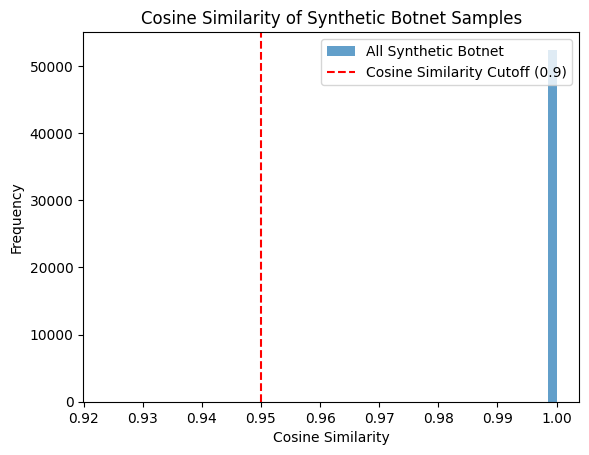

(array([2.2000e+01, 6.3000e+02, 4.2400e+02, 2.7000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.4000e+01, 1.0671e+04,
        2.9745e+04, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0945e+04]),
 array([0.22356993, 0.23909853, 0.25462713, 0.27015573, 0.28568433,
        0.30121293, 0.31674153, 0.33227013, 0.34779873, 0.36332733,
        0.37885593, 0.39438453, 0.40991313, 0.42544173, 0.44097033,
        0.45649893, 0.47202753, 0.48755613, 0.50308473, 0.51861333,
        0.53414193, 0.54967053, 0.56519913, 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Spam Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

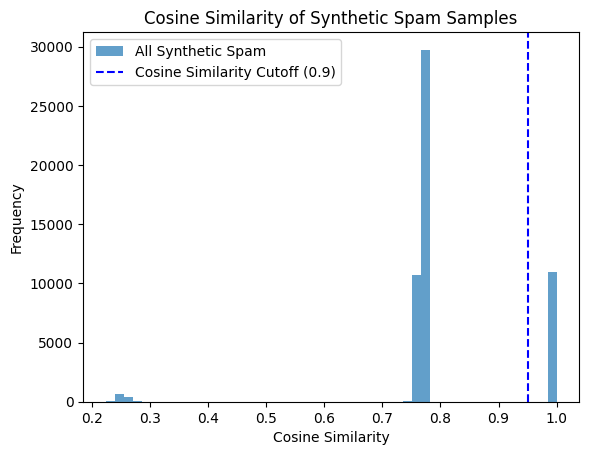

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

cos_sim_botnet = cosine_similarity(X_synth_botnet_scaled, X_real_botnet_scaled).max(axis=1)
cos_sim_spam = cosine_similarity(X_synth_spam_scaled, X_real_spam_scaled).max(axis=1)

threshold_botnet = 0.95
filtered_X_botnet_synth = botnet_gen[cos_sim_botnet > threshold_botnet]
threshold_spam = 0.95
filtered_X_spam_synth = spam_gen[cos_sim_spam > threshold_spam]

print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

# visualize
plt.hist(cos_sim_botnet, bins=50, alpha=0.7, label='All Synthetic Botnet')
plt.axvline(threshold_botnet, color='red', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Botnet Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(cos_sim_spam, bins=50, alpha=0.7, label='All Synthetic Spam')
plt.axvline(threshold_spam, color='blue', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Spam Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

class_names = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}
X = dfjuly.drop(columns=['Class'])
y = dfjuly['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')
X_train = pd.concat([X_train_orig, filtered_X_botnet_synth], ignore_index=True)
X_train = pd.concat([X_train, filtered_X_spam_synth], ignore_index=True)


y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_X_botnet_synth))], ignore_index=True)
y_train = pd.concat([y_train, pd.Series([4] * len(filtered_X_spam_synth))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test = X_test[X_train.columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

#fit
mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=[class_names[i] for i in range(len(class_names))],
                     columns=[class_names[i] for i in range(len(class_names))])
print(cm_df)
fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")
y_proba = mlp_classifier.predict_proba(X_test_scaled)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[classes[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"{class_names[k]}: {v:.4f}")


Label distribution in training set:
 2    53859
0    21000
4    12345
3    12250
1    12250
Name: count, dtype: int64


MLPClassifier(random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      9000
           1       1.00      1.00      1.00      5250
           2       0.96      0.89      0.92       600
           3       0.99      1.00      0.99      5250
           4       0.76      0.86      0.81       600

    accuracy                           0.98     20700
   macro avg       0.94      0.94      0.94     20700
weighted avg       0.98      0.98      0.98     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    8738     3      21    76   162
DoS          0  5250       0     0     0
Botnet      68     0     532     0     0
Scan         8     0       0  5242     0
Spam        86     0       0     0   514

False Negative Rate (FNR) per class:
Benign: 0.0291
DoS: 0.0000
Botnet: 0.1133
Scan: 0.0015
Spam: 0.1433

False Positive Rate (FPR) per class:
Benign: 0.0138
DoS: 0.0002
Botnet: 0.0010
Scan: 0.0049
Spam: 0.0081


In [ ]:
filtered_X_botnet_synth.to_csv('TVAE_cosine_botnet_July.csv', index=False)
filtered_X_spam_synth.to_csv('TVAE_cosine_July.csv', index=False)